# SNPS ANALYSIS OF MOUSE RIBOSOME PROFILING AND RNA-SEQ DATA

In [39]:
import gzip
import pandas as pd
import numpy as np
import os

from multiprocessing import Pool
from matplotlib import pyplot as plt
from functools import reduce



# We use rpy2 for the prop.test and padjust in R
import rpy2
from rpy2 import robjects
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr


from IPython.display import display, HTML

In [40]:
%load_ext rpy2.ipython
%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 8]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Constants

In [98]:
# The values of the confidence interval coming from the proptest
# must be less than this value
PROPTEST_ERROR_THRESHOLD = 0.05

# After adjusting the p-values of the proptest
# we pick the FDR values less than this threshold
FDR_THRESHOLD = 0.05

## Input & Output Folders

In [41]:
INPUT_FOLDER  = "."
OUTPUT_FOLDER = "snp_dataframes"

if not os.path.isdir(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

In [42]:
# RNA_SEQ EXPERIMENTS
# Note that we excluded the experiment 20210607-RNAseq-4cell-cross-B

rnaseq_one_cell_exps = [
"20210607-RNAseq-1cell-cross-A",
"20210607-RNAseq-1cell-cross-B",
"20210607-RNAseq-1cell-cross-C",
"20210607-RNAseq-1cell-cross-D"]

rnaseq_two_cell_exps = [
"20210607-RNAseq-2cell-cross-A",
"20210607-RNAseq-2cell-cross-B",
"20210607-RNAseq-2cell-cross-C",
"20210607-RNAseq-2cell-cross-D"
]

rnaseq_four_cell_exps = [
"20210607-RNAseq-4cell-cross-A",
#"20210607-RNAseq-4cell-cross-B",
"20210607-RNAseq-4cell-cross-C"
]

rnaseq_eight_cell_exps = [
"20210607-RNAseq-8cell-cross-A",
"20210607-RNAseq-8cell-cross-B",
"20210607-RNAseq-8cell-cross-C",
"20210607-RNAseq-8cell-cross-D"
]

rnaseq_gv_epxs = [
"20210607-RNAseq-GV-A",
"20210607-RNAseq-GV-B",
"20210607-RNAseq-GV-C",
"20210607-RNAseq-GV-D"
]

rnaseq_mii_exps = [
"20210607-RNAseq-MII-A",
"20210607-RNAseq-MII-B",
"20210607-RNAseq-MII-C",
"20210607-RNAseq-MII-D"
]

rnaseq_all_exps = rnaseq_one_cell_exps + rnaseq_two_cell_exps + \
                  rnaseq_four_cell_exps + rnaseq_eight_cell_exps +\
                  rnaseq_gv_epxs + rnaseq_mii_exps

In [43]:
## RIBOSOME PROFILING EXPERIMENTS

riboseq_one_cell_exps = [
"20210513-ITP-1cell-cross-50-A",
"20210513-ITP-1cell-cross-50-B",
"20210513-ITP-1cell-cross-50-C",
"20210513-ITP-1cell-cross-50-D",
"20210513-ITP-1cell-cross-50-E"]
    
riboseq_two_cell_exps = [
"20210513-ITP-2cell-cross-50-B",
"20210513-ITP-2cell-cross-50-C",
"20210513-ITP-2cell-cross-50-F",
]

riboseq_four_cell_exps = [
"20210513-ITP-4cell-cross-50-B",
"20210513-ITP-4cell-cross-50-C",
"20210513-ITP-4cell-cross-50-D",
]
    
riboseq_eigth_cell_exps = [
"20210513-ITP-8cell-cross-50-A",
"20210513-ITP-8cell-cross-50-B",
"20210513-ITP-8cell-cross-50-C",
"20210513-ITP-8cell-cross-50-D",
]
    
    
riboseq_mii_exps = [
"20210301-ITP-MII-25-B",
"20210301-ITP-MII-50-A",
"20210301-ITP-MII-50-B",
"20210318-ITP-MII-50-B",
"20210614-ITP-MII-50-A",
#"20210614-ITP-MII-50-B",
"20210614-ITP-MII-50-C",
"20210614-ITP-MII-50-D",
"20210614-ITP-MII-50-E",
"20210614-ITP-MII-50-F",
]    
    
    
riboseq_gv_epxs = [
"20210614-ITP-GV-50-A",
"20210614-ITP-GV-50-B",
"20210614-ITP-GV-50-C",
"20210614-ITP-GV-50-D",
"20210614-ITP-GV-50-E",
"20210614-ITP-GV-50-F",
]

riboseq_all_exps = riboseq_one_cell_exps  + riboseq_two_cell_exps + \
                   riboseq_four_cell_exps + riboseq_eigth_cell_exps + \
                   riboseq_mii_exps       + riboseq_gv_epxs

In [44]:
## FUNCTIONS TO READ SNP FILES

In [45]:
def extract_CDS(name_str):
    """
    Returns CDS boundaries from the transcript header
    """
    
    contents = name_str.split("|")
    
    for c in contents:
        if c.startswith("CDS"):
            boundaries = c.split(":")[1].split("-")
            return (int(boundaries[0]), int(boundaries[1]))
    
    print(name_str)
    raise ValueError 
    
    
    
############################################################
    
    
    
def get_df(snp_count_file):
    """
    Reads SNP cont file into a dataframe
    """
    
    count_df         = pd.read_csv(snp_count_file, sep = "\t")
    transcript_names = list( map( lambda x: x.split("|")[4], count_df["transcript"]) )

    boundaries       = list( map(extract_CDS, count_df["transcript"])  )

    start_positions  = list( map(lambda x: x[0], boundaries ) )
    stop_positions   = list( map(lambda x: x[1], boundaries ) )

    snp_total = count_df["A"] + count_df["C"] + count_df["G"] +  count_df["T"]

    count_df["transcript"] = transcript_names
    count_df["snp_total"]  = snp_total
    count_df["CDS_start"]  = start_positions
    count_df["CDS_stop"]   = stop_positions


    count_df.sort_values(by = ['snp_total'], ascending=False, inplace=True)
    
    return count_df    

#################################################################

def get_ref_alt_counts(count_df):
    """
    Extracts the reference (maternal) and alternative (paternal) 
    counts from the dataframes
    """
    
    ref_count   = 0
    alt_count   = 0
    total_count = 0
    
    cds_ref_count   = 0
    cds_alt_count   = 0
    cds_total_count = 0

    for index, row in count_df.iterrows():
        total_count += row["A"] + row["C"] + row["G"] + row["T"]
        ref_count   += row[ row["REF"] ]
        alt_count   += row[ row["ALT"] ]
        
        if row["position"] >= row["CDS_start"] and\
           row["position"] <= row["CDS_stop"]:
                cds_total_count += row["A"] + row["C"] + row["G"] + row["T"]
                cds_ref_count   += row[ row["REF"] ]
                cds_alt_count   += row[ row["ALT"] ]            

        
    return {"ref_count":     ref_count,     "alt_count": alt_count,         "total_count": total_count,
            "cds_ref_count": cds_ref_count, "cds_alt_count": cds_alt_count, "cds_total_count": cds_total_count}

## RNA-Seq SNP Calls

We read SNP calls from RNA-Seq into dataframes.

In [46]:
rnaseq_experiment_dfs = dict()

for e in rnaseq_all_exps:
    this_file = os.path.join( INPUT_FOLDER, "snp_counts_rnaseq", e + ".tsv.gz")
    rnaseq_experiment_dfs[e] = get_df(this_file)
    rnaseq_experiment_dfs[e]["experiment"] = e
    
rnaseq_reference_alt_counts = dict()

with Pool(4) as p:
    rnaseq_counts_array = p.map( get_ref_alt_counts, [ rnaseq_experiment_dfs[e] for e in rnaseq_all_exps ] )
    
for i in range(len(rnaseq_all_exps)):
    rnaseq_reference_alt_counts[rnaseq_all_exps[i]] = rnaseq_counts_array[i]
    


In [47]:
#Uncomment to get the count
#for e in rnaseq_all_exps:
#    print(e)
#    print(rnaseq_reference_alt_counts[e])

In [48]:
rnaseq_snp_count_df  = pd.DataFrame.from_dict(rnaseq_reference_alt_counts).transpose()
rnseq_snp_count_file = os.path.join(OUTPUT_FOLDER, "rnaseq_experimentwise_snp_counts.csv")
rnaseq_snp_count_df.to_csv(rnseq_snp_count_file)

rnaseq_snp_count_df[:2]

,ref_count,alt_count,total_count,cds_ref_count,cds_alt_count,cds_total_count
20210607-RNAseq-1cell-cross-A,179914,314,180540,179914,314,180540
20210607-RNAseq-1cell-cross-B,180976,373,181700,180976,373,181700


In [49]:
def calculate_ref_alt_percentages(count_dict):
    ref_percentage = (count_dict["ref_count"] / count_dict["total_count"] ) * 100
    alt_percentage = (count_dict["alt_count"] / count_dict["total_count"] ) * 100
    
    cds_ref_percentage = (count_dict["cds_ref_count"] / count_dict["cds_total_count"] ) * 100
    cds_alt_percentage = (count_dict["cds_alt_count"] / count_dict["cds_total_count"] ) * 100
    
    return {"ref_percentage": ref_percentage, "alt_percentage" : alt_percentage,
           "cds_ref_percentage": cds_ref_percentage, "cds_alt_percentage" : cds_alt_percentage}

In [50]:
def calculate_ref_alt_percentages(count_dict):
    ref_percentage = (count_dict["ref_count"] / count_dict["total_count"] ) * 100
    alt_percentage = (count_dict["alt_count"] / count_dict["total_count"] ) * 100
    
    cds_ref_percentage = (count_dict["cds_ref_count"] / count_dict["cds_total_count"] ) * 100
    cds_alt_percentage = (count_dict["cds_alt_count"] / count_dict["cds_total_count"] ) * 100
    
    return {"ref_percentage": ref_percentage, "alt_percentage" : alt_percentage,
           "cds_ref_percentage": cds_ref_percentage, "cds_alt_percentage" : cds_alt_percentage}

In [51]:
rnaseq_reference_alt_percentages = dict()

for e in rnaseq_all_exps:
    rnaseq_reference_alt_percentages[e] = calculate_ref_alt_percentages(rnaseq_reference_alt_counts[e])

In [52]:
# Uncomment to seethe percentages

# for e in rnaseq_all_exps:
#    print(e)
#    print("Alt: {:.1f}    Ref: {:.1f}".format( rnaseq_reference_alt_percentages[e]["cds_alt_percentage"],
#                                       rnaseq_reference_alt_percentages[e]["cds_ref_percentage"]))

In [53]:
rnaseq_experiment_dfs["20210607-RNAseq-4cell-cross-C"][:5]

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop,experiment
68514,Rps19-203,303,C,T,1,521,1,616,1139,298,735,20210607-RNAseq-4cell-cross-C
66330,Dppa3-201,290,A,C,691,403,1,0,1095,114,566,20210607-RNAseq-4cell-cross-C
4478,Rps26-201,299,C,T,0,505,0,517,1022,270,617,20210607-RNAseq-4cell-cross-C
66329,Dppa3-201,263,C,T,0,509,0,437,946,114,566,20210607-RNAseq-4cell-cross-C
23498,Rpl15-202,275,A,G,441,0,474,0,915,120,734,20210607-RNAseq-4cell-cross-C


## SNP Bar Charts: A Global Look at the SNPs

In [54]:
def get_barplot_df(percentage_df, experiments, cds = False):
    """
    If cds=True, then only SNPS comig from CDS are taken
    if cds=False
    SNPs coming from the ENTIRE transcript are taken
    """
    
    reference_alt_percentages = percentage_df
    
    percentage_dict = {"Experiment": experiments,  "Paternal": [], "Maternal": [], "Other": []}
    
    if cds:
        key_prefix = "cds_"
    else:
        key_prefix = ""
            

    for e in experiments:
        #print(e)
        percentage_dict["Maternal"].append( reference_alt_percentages[e][ key_prefix + "ref_percentage"]) 
        percentage_dict["Paternal"].append( reference_alt_percentages[e][key_prefix + "alt_percentage"]) 
        other = 100 - (reference_alt_percentages[e][key_prefix + "ref_percentage"] +\
                       reference_alt_percentages[e][key_prefix + "alt_percentage"])
        percentage_dict["Other"].append(other)

        #print("Alt: {:.1f}    Ref: {:.1f} Other: {:.1f}".format( \
        #                                   reference_alt_percentages[e][key_prefix + "alt_percentage"],
        #                                   reference_alt_percentages[e][key_prefix + "ref_percentage"],
        #                                   other                ))
    
    
    p_df = pd.DataFrame(percentage_dict, index=experiments)
    
    return p_df

In [55]:
rnaseq_cds_barplot_df = \
    get_barplot_df(percentage_df = rnaseq_reference_alt_percentages, 
                   experiments   = rnaseq_all_exps, 
                   cds           = True)

rnaseq_cds_barplot_df.set_index(keys = "Experiment", inplace = True)

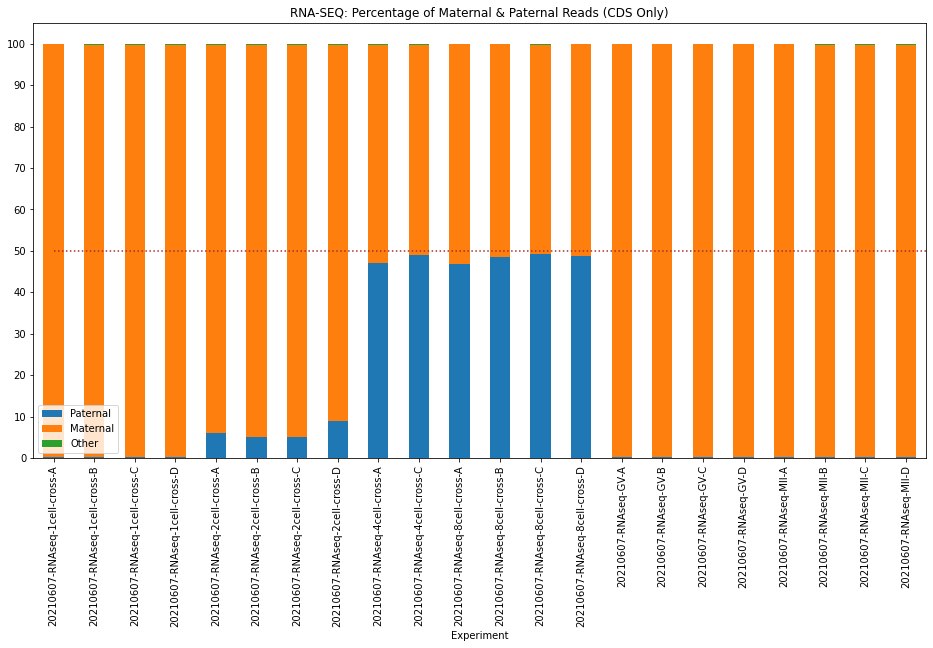

In [56]:
fig  = rnaseq_cds_barplot_df.plot(kind    = "bar", 
                                  stacked = True, 
                                  title   = "RNA-SEQ: Percentage of Maternal & Paternal Reads (CDS Only)");

plt.hlines(50, xmin=0, xmax=len(rnaseq_all_exps), linestyle=':', color="brown" );
plt.yticks(list(range(0,110, 10) ));

In [57]:
# OUTPUT THE RNASEQ SNP PERCENTAGES FILE
rnaseq_snp_percentages_file = os.path.join(OUTPUT_FOLDER, "rnaseq_snp_percentages.csv")
rnaseq_cds_barplot_df.to_csv(rnaseq_snp_percentages_file)

In [58]:
! cat snp_dataframes/rnaseq_snp_percentages.csv | head -n 3

Experiment,Paternal,Maternal,Other
20210607-RNAseq-1cell-cross-A,0.17392267641519885,99.65326243491747,0.1728148886673324
20210607-RNAseq-1cell-cross-B,0.20528343423225096,99.60154100165107,0.1931755641166717


## Ribosome Profiling SNP Calls

In [59]:
riboseq_experiment_dfs = dict()

for e in riboseq_all_exps:
    this_file = os.path.join("snp_counts_riboseq", e + ".tsv.gz")
    riboseq_experiment_dfs[e] = get_df(this_file)
    riboseq_experiment_dfs[e]["experiment"] = e
    

riboseq_reference_alt_counts = dict()

with Pool(4) as p:
    riboseq_counts_array = p.map( get_ref_alt_counts, [ riboseq_experiment_dfs[e] for e in riboseq_all_exps ] )
    
for i in range(len(riboseq_all_exps)):
    riboseq_reference_alt_counts[riboseq_all_exps[i]] = riboseq_counts_array[i]

riboseq_reference_alt_percentages = dict()

for e in riboseq_all_exps:
    riboseq_reference_alt_percentages[e] = calculate_ref_alt_percentages(riboseq_reference_alt_counts[e])

In [22]:
#for e in riboseq_all_exps:
#    print(e)
#    print("Alt: {:.1f}    Ref: {:.1f}".format( riboseq_reference_alt_percentages[e]["cds_alt_percentage"],
# 

In [63]:
riboseq_barplot_cds_df = \
    get_barplot_df(percentage_df = riboseq_reference_alt_percentages, 
                   experiments   = riboseq_all_exps, 
                   cds           = True)

riboseq_barplot_cds_df.set_index(keys = "Experiment")



,Paternal,Maternal,Other
Experiment,,,
20210513-ITP-1cell-cross-50-A,1.256003,96.983130,1.760867
20210513-ITP-1cell-cross-50-B,0.932685,97.556772,1.510543
20210513-ITP-1cell-cross-50-C,1.015572,96.750169,2.234259
20210513-ITP-1cell-cross-50-D,1.171606,96.388697,2.439697
20210513-ITP-1cell-cross-50-E,1.323877,96.028369,2.647754
20210513-ITP-2cell-cross-50-B,11.798689,86.523720,1.677591
20210513-ITP-2cell-cross-50-C,4.806034,93.017241,2.176724
20210513-ITP-2cell-cross-50-F,7.081090,90.438897,2.480013
20210513-ITP-4cell-cross-50-B,43.879685,52.678141,3.442175


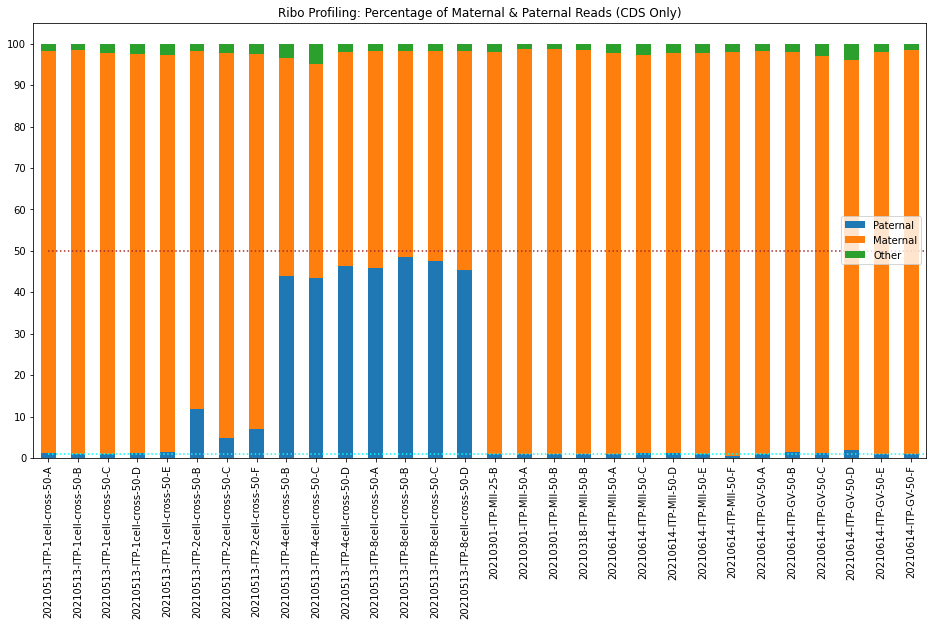

In [24]:
fig  = riboseq_barplot_cds_df.plot(kind    = "bar", 
                                  stacked = True, 
                                  title   = "Ribo Profiling: Percentage of Maternal & Paternal Reads (CDS Only)");

plt.hlines(50, xmin=0, xmax=len(riboseq_all_exps), linestyle=':', color="brown" );
plt.hlines(1, xmin=0, xmax=len(riboseq_all_exps), linestyle=':', color="cyan" );
plt.yticks(list(range(0,110, 10) ));

In [25]:
riboseq_snp_percentages_file = os.path.join(OUTPUT_FOLDER, "riboseq_snp_percentages.csv")
riboseq_barplot_cds_df.to_csv(riboseq_snp_percentages_file)
riboseq_barplot_cds_df[:2]

,Experiment,Paternal,Maternal,Other
20210513-ITP-1cell-cross-50-A,20210513-ITP-1cell-cross-50-A,1.256003,96.983130,1.760867
20210513-ITP-1cell-cross-50-B,20210513-ITP-1cell-cross-50-B,0.932685,97.556772,1.510543


In [26]:
riboseq_snp_count_df   = pd.DataFrame.from_dict(riboseq_reference_alt_counts).transpose()
riboseq_snp_count_file = os.path.join(OUTPUT_FOLDER, "riboseq_experimentwise_snp_counts.csv")
riboseq_snp_count_df.to_csv(riboseq_snp_count_file)

riboseq_snp_count_df[:2]

,ref_count,alt_count,total_count,cds_ref_count,cds_alt_count,cds_total_count
20210513-ITP-1cell-cross-50-A,7876,102,8121,7876,102,8121
20210513-ITP-1cell-cross-50-B,9623,92,9864,9623,92,9864


## SNP Data at Highest Detail

We combine all of the SNP data into one dataframe. 
For each experiment, transcript and SNP position there is a separate row with SNP information.
Note that, in our context, reference (REF) corresponds to maternal strain and alternative (ALT) corresponds to paternal strain.

In [27]:
def find_maternal_paternal_snps(this_df):
    maternal_counts = list()
    paternal_counts = list()
    
    
    for i, contents in this_df.iterrows():
        this_maternal = contents[ contents["REF"] ]
        this_paternal = contents[ contents["ALT"] ]
        paternal_counts.append(this_paternal)
        maternal_counts.append(this_maternal)
        
    this_df["maternal"] = maternal_counts
    this_df["paternal"] = paternal_counts
    
    return this_df



In [64]:
# Find ribosome profiling maternal / poaternal counts 

with Pool(4) as p:
    riboseq_detailed_count_dfs = p.map( find_maternal_paternal_snps, list(riboseq_experiment_dfs.values()) )

In [65]:
# Find rna-seq maternal / poaternal counts 

with Pool(4) as p:
    rnaseq_detailed_count_dfs = p.map( find_maternal_paternal_snps, list(rnaseq_experiment_dfs.values()) )

In [69]:
def combine_snp_dfs_into_on_df(df_list):
    
    res_columns = ["experiment", "transcript", "position", "paternal",\
                   "maternal", "REF", "ALT", "A", "C", "G", "T"]
    
    result_df   =  df_list[0].copy()
    
    for i in range(1, len(df_list)):
        result_df = result_df.append( df_list[i] )
        
    return result_df[res_columns]

In [70]:
combined_riboseq_snp_df = combine_snp_dfs_into_on_df(riboseq_detailed_count_dfs)
combined_rnaseq_snp_df  = combine_snp_dfs_into_on_df(rnaseq_detailed_count_dfs)

In [76]:
high_res_riboseq_snp_file = os.path.join(OUTPUT_FOLDER, "riboseq_detailed_snps.csv.gz")
combined_riboseq_snp_df.to_csv( high_res_riboseq_snp_file, index = False )

high_res_rnaseq_snp_file = os.path.join(OUTPUT_FOLDER, "rnaseq_detailed_snps.csv.gz")
combined_rnaseq_snp_df.to_csv( high_res_rnaseq_snp_file, index = False )

## Aggregating SNP Counts

We sum SNPs accross replicates

In [79]:
def add_two_snp_dfs(df_1, df_2):
    """
    This is the helper function to add dataframes
    
    Adds two dataframes and produces one that is compatible with other SNP dataframes
    (Have the same column names)
    """
    
    index_col_name = "trans_pos"
    
    zipped_df1_transcripts_df1_positions = zip( df_1["transcript"], df_1["position"] )
    zipped_df2_transcripts_df2_positions = zip( df_2["transcript"], df_2["position"] )
    
    df1_index_vec = list( map( lambda x: str(x[0]) + "_" + str(x[1]), zipped_df1_transcripts_df1_positions ) )
    df2_index_vec = list( map( lambda x: str(x[0]) + "_" + str(x[1]), zipped_df2_transcripts_df2_positions ) )
    
    df_1_indexed = df_1.copy()
    df_2_indexed = df_2.copy()
    
    df_1_indexed[index_col_name] = df1_index_vec
    df_2_indexed[index_col_name] = df2_index_vec
    
    df_1_indexed.set_index(index_col_name, inplace = True)
    df_2_indexed.set_index(index_col_name, inplace = True)
    
    merged_df = df_1_indexed.merge( df_2_indexed, on = ["trans_pos"] )
    
    df_dict = {
        #"trnas_pos":  merged_df.index,
        "transcript": merged_df["transcript_x"],
        "position":   merged_df["position_x"],
        "REF":        merged_df["REF_x"],
        "ALT":        merged_df["ALT_x"],
        "A":          np.add(merged_df["A_x"] , merged_df["A_y"]),
        "C":          np.add(merged_df["C_x"] , merged_df["C_y"]),
        "G":          np.add(merged_df["G_x"] , merged_df["G_y"]),
        "T":          np.add(merged_df["T_x"] , merged_df["T_y"]),
        "snp_total":  np.add(merged_df["snp_total_x"] , merged_df["snp_total_y"]),
        "CDS_start":  merged_df["CDS_start_x"],
        "CDS_stop":  merged_df["CDS_stop_x"]     
    }
    
    result_df = pd.DataFrame.from_dict(df_dict)
    
    return (result_df)


##############################################################################


def add_snp_dfs(df_list):
    """
    THIS IS THE MAIN FUNCTION TO CALL!!!
    Adds a list of dataframes containing SNPS
    """
    result_df =  reduce( lambda x, y : add_two_snp_dfs(x,y), df_list  )
    result_df.sort_values(by = ['snp_total'], ascending=False, inplace=True)
    return result_df

In [80]:
add_two_snp_dfs( riboseq_experiment_dfs[riboseq_one_cell_exps[0]], riboseq_experiment_dfs[riboseq_one_cell_exps[1]] )

,transcript,position,REF,ALT,A,C,G,T,snp_total,CDS_start,CDS_stop
trans_pos,,,,,,,,,,,
Spin1-201_848,Spin1-201,848,C,G,0,320,2,1,323,261,1049
Zbed3-202_471,Zbed3-202,471,T,C,0,0,0,217,217,174,860
Zbed3-202_707,Zbed3-202,707,A,G,218,0,0,0,218,174,860
E330034G19Rik-203_257,E330034G19Rik-203,257,A,C,125,0,0,0,125,56,1111
Zbed3-202_320,Zbed3-202,320,T,G,8,2,10,130,150,174,860
...,...,...,...,...,...,...,...,...,...,...,...
Gpd1-201_825,Gpd1-201,825,T,C,0,0,0,0,0,94,1143
Gpd1-201_508,Gpd1-201,508,C,T,0,0,0,0,0,94,1143
Gpd1-201_462,Gpd1-201,462,C,T,0,0,0,0,0,94,1143


In [81]:
riboseq_snp_total_one_cell   = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_one_cell_exps] )
riboseq_snp_total_two_cell   = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_two_cell_exps] )
riboseq_snp_total_four_cell  = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_four_cell_exps] )
riboseq_snp_total_eight_cell = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_eigth_cell_exps] )


riboseq_snp_total_mii = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_mii_exps] )
riboseq_snp_total_gv  = add_snp_dfs( [riboseq_experiment_dfs[e] for e in  riboseq_gv_epxs] )

In [82]:
rnaseq_snp_total_one_cell   = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_one_cell_exps] )
rnaseq_snp_total_two_cell   = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_two_cell_exps] )
rnaseq_snp_total_four_cell  = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_four_cell_exps] )
rnaseq_snp_total_eight_cell = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_eight_cell_exps] )


rnaseq_snp_total_mii = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_mii_exps] )
rnaseq_snp_total_gv  = add_snp_dfs( [rnaseq_experiment_dfs[e] for e in  rnaseq_gv_epxs] )

We add the paternal / maternal counts ratios to our dataframes

In [83]:
def find_maternal_ratio(snp_df):
    maternal_ratios      = list()
    maternal_count       = list()
    paternal_count       = list()
    mat_pat_count        = list()
    
    for i, e in snp_df.iterrows():
        
        maternal_nuc  = e["REF"]
        paternal_nuc  = e["ALT"]
        mat_pat_total = e[maternal_nuc] + e[paternal_nuc]
        
        # Avoid division by 0
        if mat_pat_total == 0:
            mat_pat_total = 1
            
        maternal_ratio = e[maternal_nuc] / mat_pat_total
        
        mat_pat_count.append(mat_pat_total)
        maternal_ratios.append(maternal_ratio)
        maternal_count.append(e[maternal_nuc])
        paternal_count.append(e[paternal_nuc])
        
    snp_df["maternal_count"] = maternal_count 
    snp_df["paternal_count"] = paternal_count 
    snp_df["mat_pat_total"]  = mat_pat_count 
    snp_df["maternal_ratio"] = maternal_ratios

In [84]:
find_maternal_ratio( riboseq_snp_total_one_cell )
find_maternal_ratio( riboseq_snp_total_two_cell ) 
find_maternal_ratio( riboseq_snp_total_four_cell ) 
find_maternal_ratio( riboseq_snp_total_eight_cell )

find_maternal_ratio( riboseq_snp_total_mii )
find_maternal_ratio( riboseq_snp_total_gv ) 

In [85]:
find_maternal_ratio( rnaseq_snp_total_one_cell )
find_maternal_ratio( rnaseq_snp_total_two_cell ) 
find_maternal_ratio( rnaseq_snp_total_four_cell ) 
find_maternal_ratio( rnaseq_snp_total_eight_cell ) 

find_maternal_ratio( rnaseq_snp_total_mii )
find_maternal_ratio( rnaseq_snp_total_gv )

## Proportionality Test

In R, we use the following function to compare proportions.
```
prop.test( paternal, total )
```

Note that the above test tells us whether `paternal_ribo / total_ribo` is significantly different than
`paternal_rna / total_rna`.

`paternal` has two components: (ribo_paternal, rnaseq_paternal)

`total` comdes from the sum of paternal and maternal counts. 

Namely,
(ribo_paternal + ribo_maternal, rnaseq_paternal + rnaseq_maternal)

In [93]:
proptest = robjects.r('prop.test')

def perform_prop_test(df_1, df_2, error_threshold = 0.01):
    """
    Decide whether paternal  ratios differ between df_1 and df_2
    
    Insufficient counts are marked with the p-value 10.
    
    If the difference between the proportionsare less than the error threshold, 
    they are marked with the p-value 5.
    """
    
    pvalues        = []
    conf_midpoints = []

    merged_df = df_1.merge(df_2, on = "trans_pos")
    
    for i, e in merged_df.iterrows():
        #print(i, e)
        
        # Mark insufficient counts with p-val 10 and exclude them from the test
        if (e["maternal_count_x"]+ e["paternal_count_x"]) < 10  or\
           (e["maternal_count_y"] + e["paternal_count_y"]) < 10 :
            pvalues.append(10)
            conf_midpoints.append(10)
            continue
        
        
        if e["maternal_count_x"]+ e["maternal_count_y"] == 0 or\
           e["paternal_count_x"] + e["paternal_count_y"] == 0 :
            
            #print("detected zero at", i)
            pvalues.append(10)
            conf_midpoints.append(10)
            continue
            
        if e["paternal_count_x"] <=2 and e["paternal_count_y"] <= 2:
            pvalues.append(10)
            conf_midpoints.append(10)
            continue
        
        r_paternal_counts = robjects.IntVector([ e["paternal_count_x"], e["paternal_count_y"] ])
        r_total_counts    = robjects.IntVector([ e["paternal_count_x"] + e["maternal_count_x"], 
                                                 e["paternal_count_y"] + e["maternal_count_y"] ])
        
        proptest_result = proptest(r_paternal_counts, r_total_counts)
        result_dict     = dict(proptest_result.items())
        conf_int        = result_dict["conf.int"]
        mid_point_conf  = (conf_int[0] + conf_int[1]) / 2
        
        
        if conf_int[1] < 0 and error_threshold > ((-1) * conf_int[1]):
            this_p_val = 5
        elif conf_int[1] >=0 and (error_threshold > conf_int[0]):
            this_p_val = 5
        else:
            this_p_val = proptest_result[2][0]
        
        
        pvalues.append(this_p_val)
        conf_midpoints.append(mid_point_conf)

        
    result_dict = { #"trans_pos" : merged_df["trans_pos"],
                    "p_val":      pvalues,
                    "conf_mid":   conf_midpoints,
                    "maternal_x": merged_df["maternal_count_x"],
                    "paternal_x": merged_df["paternal_count_x"],
                    "maternal_y": merged_df["maternal_count_y"],
                    "paternal_y": merged_df["paternal_count_y"]}
    
    
    
    result_df =  pd.DataFrame.from_dict( result_dict )
    
    return result_df

## Transcript Level SNPs

We aggregate paternal & paternal counts of transcripts. Next, we determine transcripts chaning behavior ( in terms of paternal / maternal ratio). 

In [86]:
def get_transcript_level_counts(snp_df):
    result_dict = {}
    
    for g in snp_df["transcript"]:
        result_dict[g] = { "transcript": g, "maternal_count": 0, "paternal_count": 0 }
        #result_dict[g] = { "maternal_count": 0, "paternal_count": 0 }
        
    for i, e in snp_df.iterrows():
        
        g = e["transcript"]
        
        result_dict[g]["maternal_count"] += e["maternal_count"] 
        result_dict[g]["paternal_count"] += e["paternal_count"]
        
    result_df = pd.DataFrame.from_dict( result_dict ).transpose()
    result_df.index.rename("trans_pos", inplace = True)

    
    return result_df

In [87]:
riboseq_t_level_snp_total_gv         = get_transcript_level_counts(riboseq_snp_total_gv)
riboseq_t_level_snp_total_mii        = get_transcript_level_counts(riboseq_snp_total_mii )
riboseq_t_level_snp_total_one_cell   = get_transcript_level_counts(riboseq_snp_total_one_cell )
riboseq_t_level_snp_total_two_cell   = get_transcript_level_counts(riboseq_snp_total_two_cell )
riboseq_t_level_snp_total_four_cell  = get_transcript_level_counts(riboseq_snp_total_four_cell )
riboseq_t_level_snp_total_eight_cell = get_transcript_level_counts(riboseq_snp_total_eight_cell )

In [88]:
rnaseq_t_level_snp_total_mii        = get_transcript_level_counts(rnaseq_snp_total_mii )
rnaseq_t_level_snp_total_gv         = get_transcript_level_counts(rnaseq_snp_total_gv )
rnaseq_t_level_snp_total_one_cell   = get_transcript_level_counts(rnaseq_snp_total_one_cell )
rnaseq_t_level_snp_total_two_cell   = get_transcript_level_counts(rnaseq_snp_total_two_cell )
rnaseq_t_level_snp_total_four_cell  = get_transcript_level_counts(rnaseq_snp_total_four_cell )
rnaseq_t_level_snp_total_eight_cell = get_transcript_level_counts(rnaseq_snp_total_eight_cell )

### Perform PropTest

In [94]:


proptest_t_level_gv_ribo_rna         = perform_prop_test( riboseq_t_level_snp_total_gv, 
                                                          rnaseq_t_level_snp_total_gv,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_mii_ribo_rna        = perform_prop_test( riboseq_t_level_snp_total_mii, 
                                                          rnaseq_t_level_snp_total_mii,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_one_cell_ribo_rna   = perform_prop_test( riboseq_t_level_snp_total_one_cell, 
                                                          rnaseq_t_level_snp_total_one_cell,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_two_cell_ribo_rna   = perform_prop_test( riboseq_t_level_snp_total_two_cell, 
                                                          rnaseq_t_level_snp_total_two_cell,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_four_cell_ribo_rna  = perform_prop_test( riboseq_t_level_snp_total_four_cell, 
                                                          rnaseq_t_level_snp_total_four_cell,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

proptest_t_level_eight_cell_ribo_rna = perform_prop_test( riboseq_t_level_snp_total_eight_cell, 
                                                          rnaseq_t_level_snp_total_eight_cell,
                                                          error_threshold = PROPTEST_ERROR_THRESHOLD)

In [95]:
proptest_t_level_four_cell_ribo_rna.sort_values("p_val")[:5]

,p_val,conf_mid,maternal_x,paternal_x,maternal_y,paternal_y
trans_pos,,,,,,
Nin-202,0.000324,-0.389946,25,7,36,56
Rps11-201,0.000987,0.217296,16,47,1435,1610
Mrps9-201,0.001033,-0.608108,10,0,29,45
Rpl28-201,0.001153,0.523810,0,12,132,120
Eif3d-201,0.001333,-0.536232,11,1,35,57


## Filtering PropTest Results

We exclude the proptest results where the confidence interval of the diffrence between the ribo and rna ratios is below a certain threshold (see below number). These values are marked with the p-value 5 in the result tables.

We also add the FDR value to the results.

In [96]:
padjust = robjects.r("p.adjust")


def filter_and_padjust_proptest_results( input_df , threshold = 2 ):
    
    #result_df = input_df[t_index]
    # exclude obvious cases marked with p values >= 5
    result_df = input_df[ input_df["p_val"] < 5 ]
    
    result_df = result_df[ np.logical_not(np.isclose(result_df["p_val"] , 1) ) ]
    
    
    
    p_values         = robjects.FloatVector( result_df["p_val"] )
    r_fdr_values     = padjust( p_values, method = "fdr" )
    result_df["fdr"] = [float(x) for x in r_fdr_values] 
    
    
    return result_df

In [97]:
filtered_proptest_t_level_gv_ribo_rna         = filter_and_padjust_proptest_results(proptest_t_level_gv_ribo_rna)
filtered_proptest_t_level_mii_ribo_rna        = filter_and_padjust_proptest_results(proptest_t_level_mii_ribo_rna)
filtered_proptest_t_level_one_cell_ribo_rna   = filter_and_padjust_proptest_results(proptest_t_level_one_cell_ribo_rna)
filtered_proptest_t_level_two_cell_ribo_rna   = filter_and_padjust_proptest_results(proptest_t_level_two_cell_ribo_rna)
filtered_proptest_t_level_four_cell_ribo_rna  = filter_and_padjust_proptest_results(proptest_t_level_four_cell_ribo_rna)
filtered_proptest_t_level_eight_cell_ribo_rna = filter_and_padjust_proptest_results(proptest_t_level_eight_cell_ribo_rna)

## Arranging PropTest Results

In [99]:
interesting_genes = dict()

In [124]:
one_cell_selected_entries = filtered_proptest_t_level_one_cell_ribo_rna[\
                                        filtered_proptest_t_level_one_cell_ribo_rna["fdr"] < FDR_THRESHOLD]\
                                            .sort_values(by="fdr")

interesting_genes[1] = list( one_cell_selected_entries.index )

one_cell_proptest_result_file = os.path.join(OUTPUT_FOLDER, "one_cell_proptest_results.csv")


one_cell_selected_entries.rename_axis( "transcript").to_csv(one_cell_proptest_result_file)

In [125]:
two_cell_selected_entries = filtered_proptest_t_level_two_cell_ribo_rna[\
                                filtered_proptest_t_level_two_cell_ribo_rna["fdr"] < FDR_THRESHOLD]\
                                   .sort_values(by="fdr")

interesting_genes[2] = list(two_cell_selected_entries.index)

two_cell_proptest_result_file = os.path.join(OUTPUT_FOLDER, "two_cell_proptest_results.csv")
two_cell_selected_entries.rename_axis( "transcript").to_csv(two_cell_proptest_result_file)

In [126]:
four_cell_selected_entries = filtered_proptest_t_level_four_cell_ribo_rna[\
                                            filtered_proptest_t_level_four_cell_ribo_rna["fdr"] < FDR_THRESHOLD]\
                                                   .sort_values(by="fdr")

interesting_genes[4] = list( four_cell_selected_entries.index )

four_cell_proptest_result_file = os.path.join(OUTPUT_FOLDER, "four_cell_proptest_results.csv")
four_cell_selected_entries.rename_axis( "transcript").to_csv( four_cell_proptest_result_file )

In [127]:
eight_cell_selected_entries = filtered_proptest_t_level_eight_cell_ribo_rna[\
                                        filtered_proptest_t_level_eight_cell_ribo_rna["fdr"] < FDR_THRESHOLD]\
                                                  .sort_values(by="fdr")

interesting_genes[8] = list( eight_cell_selected_entries.index )

eight_cell_proptest_result_file = os.path.join(OUTPUT_FOLDER, "eight_cell_proptest_results.csv")
eight_cell_selected_entries.rename_axis( "transcript").to_csv( eight_cell_proptest_result_file )

In [128]:
set_of_interesting_genes = set(interesting_genes[1] + interesting_genes[2] +\
                               interesting_genes[4] + interesting_genes[8])

print("We initially found a total of {} genes passing the proptest".format(len(set_of_interesting_genes)))

We initially found a total of 112 genes passing the proptest


In [130]:
ribo_transcript_snp_count_dfs = [riboseq_t_level_snp_total_gv, riboseq_t_level_snp_total_mii, 
                            riboseq_t_level_snp_total_one_cell, riboseq_t_level_snp_total_two_cell,
                            riboseq_t_level_snp_total_four_cell, riboseq_t_level_snp_total_eight_cell]

rna_transcript_snp_count_dfs = [rnaseq_t_level_snp_total_gv, rnaseq_t_level_snp_total_mii,
                                rnaseq_t_level_snp_total_one_cell, rnaseq_t_level_snp_total_two_cell,
                                rnaseq_t_level_snp_total_four_cell, rnaseq_t_level_snp_total_eight_cell]


def get_transcript_ratios(transcript):

    prefix = "paternal"
    ribo_paternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"] ) for x in ribo_transcript_snp_count_dfs ]
    prefix = "maternal"
    ribo_maternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in ribo_transcript_snp_count_dfs ]

    # Avoid division by 0
    #for i ,v in enumerate(ribo_maternal_counts):
    #    if v == 0:
    #        ribo_maternal_counts[i] = 1
    
    prefix = "paternal"
    rna_paternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in rna_transcript_snp_count_dfs ]
    prefix = "maternal"
    rna_maternal_counts = [ int(x[ x["transcript"] == transcript][prefix+"_count"]) for x in rna_transcript_snp_count_dfs ]

    # Avoid division by 0
    #for i , v in enumerate(rna_maternal_counts):
    #    if v == 0:
    #        rna_maternal_counts[i] = 1
    
    ribo_ratios = np.divide( ribo_paternal_counts, ribo_maternal_counts )
    rna_ratios  = np.divide( rna_paternal_counts, rna_maternal_counts )
    
    ribo_total_ratios = np.divide( ribo_paternal_counts, np.add( ribo_paternal_counts , ribo_maternal_counts ) )
    rna_total_ratios  = np.divide( rna_paternal_counts, np.add( rna_paternal_counts , rna_maternal_counts ) )
    ####!!!!!
    # Remove pseodo count from maternals if paternal / total visuals look good
    
    result_dict = {
        "ribo_ratios"          : ribo_total_ratios,
        "rna_ratios"           : rna_total_ratios,
        #"ribo_ratios"          : ribo_ratios,
        #"rna_ratios"           : rna_ratios,
        #"ribo_total_ratios"    : ribo_total_ratios,
        #"rna_total_ratios"     : rna_total_ratios,
        "ribo_paternal_counts" : ribo_paternal_counts,
        "ribo_maternal_counts" : ribo_maternal_counts,
        "rna_paternal_counts"  : rna_paternal_counts,
        "rna_maternal_counts"  : rna_maternal_counts
    }
    
    return( result_dict )

In [135]:
exp_types  = ["mii", "1", "2", "4", "8"] 

# RIBO RATIOS
df_dict = dict([ (x, {}) for x in exp_types ])

for g in set_of_interesting_genes:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict[e][g] = a["ribo_ratios"][i+1]
        
ribo_ratios_df = pd.DataFrame.from_dict(df_dict).transpose()

# RNA RATIOS
df_dict = dict([ (x, {}) for x in exp_types ])

for g in set_of_interesting_genes:
    a = get_transcript_ratios(g)
    for i, e in enumerate(exp_types):
        df_dict[e][g] = a["rna_ratios"][i+1]
        
rna_ratios_df = pd.DataFrame.from_dict(df_dict).transpose()


ribo_to_rna_ratios = ribo_ratios_df  - rna_ratios_df


mii_proptest_at_interesting_genes = proptest_t_level_mii_ribo_rna.loc[set_of_interesting_genes]

genes_with_paternal_reads_in_mii = \
    set(mii_proptest_at_interesting_genes[ \
            np.logical_or(mii_proptest_at_interesting_genes["paternal_x"] > 0, 
                          mii_proptest_at_interesting_genes["paternal_y"] > 0) ].index)

refined_gene_selection = list(\
                              set_of_interesting_genes.difference(genes_with_paternal_reads_in_mii)
                             )

print("{} refined genes selected".format(len(refined_gene_selection)))

refined_ribo_ratios_df        = ribo_ratios_df[refined_gene_selection]
refined_rna_ratios_df         = rna_ratios_df[refined_gene_selection]
refined_ribo_to_rna_ratios_df = ribo_to_rna_ratios[ refined_gene_selection]


refined_ribo_to_rna_ratios_file = os.path.join(OUTPUT_FOLDER, "refined_ribo_to_rna_ratios.csv")

refined_ribo_to_rna_ratios_df.to_csv(refined_ribo_to_rna_ratios_file)


###############################################################################
### We output another dataframe where it puts "*" for the genes that are significant
# (WRT proptest)
# We will use that to annotate the heatmap

filter_results_dfs = [filtered_proptest_t_level_one_cell_ribo_rna, 
                         filtered_proptest_t_level_two_cell_ribo_rna,
                         filtered_proptest_t_level_four_cell_ribo_rna,
                         filtered_proptest_t_level_eight_cell_ribo_rna]

binary_result_dfs =  [filtered_proptest_t_level_mii_ribo_rna,] + filter_results_dfs

test_binary_result_dict = dict([ (x, {}) for x in exp_types ])

#for g in refined_ribo_to_rna_ratios_df_05.columns:
    
    
for g in refined_ribo_to_rna_ratios_df.columns:
    for i, e in enumerate(exp_types):
        proptest_result_is_significant = ""
        
        try:
            this_data        = binary_result_dfs[i].loc[g]
            if this_data["fdr"] < FDR_THRESHOLD:
                proptest_result_is_significant = "*"
        except KeyError:
            pass
        
        test_binary_result_dict[e][g] = proptest_result_is_significant
        
test_binary_result_df   =  pd.DataFrame.from_dict(test_binary_result_dict).transpose()
test_binary_result_file = os.path.join(OUTPUT_FOLDER, "refined_ribo_to_rna_binary_significance.csv")
test_binary_result_df.to_csv(test_binary_result_file)


/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/home/hakan/miniconda3/envs/ribo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


80 refined genes selected
